In [1]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
data = np.load('data_codingset_ash.npz')

#print(data['label'])
data_ash = np.array(data['data_ash'])
label = np.array(data['label'])[0]

#print(np.array(data['label'])[0])

print(data_ash.shape)

#plt.imshow(val_images[0])

(1000, 256, 256)


In [3]:
train_images, rest_images, train_label, rest_label = train_test_split(data_ash, label, test_size=0.4, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(rest_images, rest_label, test_size=0.3, random_state=13052020)

print(test_labels)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 256, 256 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 2
train_labels = tensorflow.keras.utils.to_categorical(train_label, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

[0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.]


In [4]:
print(sigma_train)

36.770448188628336


In [5]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (600, 256, 256, 1)
 > labels: (600, 2)
Validation set:
 > images: (280, 256, 256, 1)
 > labels: (280, 2)
Test set:
 > images: (120, 256, 256, 1)
 > labels: (120, 2)


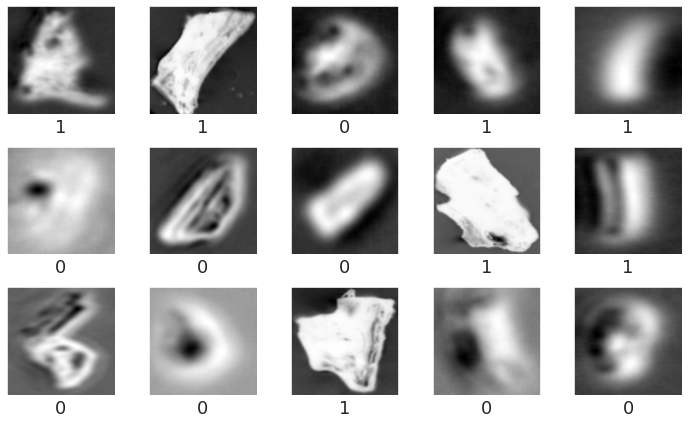

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))

N = 256

for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

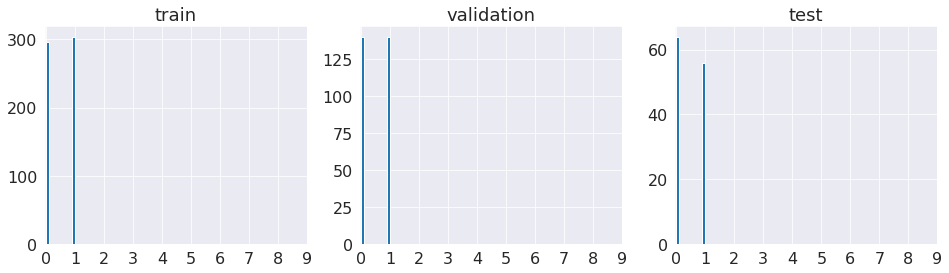

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(10)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(10)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(10)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

In [17]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch


class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        #Last_layer = Dense(units=1024, activation='relu') 
        model.add(Conv2D(filters=32,
                         kernel_size=3,
                         strides=1,
                         padding='same',
                         activation='relu',
                         input_shape=(img_rows, img_cols, 1)))

        model.add(MaxPooling2D(pool_size=2, strides=None))


        model.add(Conv2D(filters=64,
                         kernel_size=3,
                         strides=1,
                         padding='same',
                         activation='relu'))

        model.add(MaxPooling2D(pool_size=2, strides=None))

        model.add(Dropout(rate=0.40))

        model.add(Flatten())

        model.add(Dense(units=1000, activation='relu'))

        #model.add(Last_layer)

        #model.add(Dense(units=1024, activation='relu'))

        #model.add(Dense(units=1024, activation='relu'))

        model.add(Dense(units=num_classes, activation='softmax'))

        model.summary()
        return model


NUM_CLASSES = 10  # cifar10 number of classes
INPUT_SHAPE = (32, 32, 3)  # cifar10 images input shape
    
    
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)


HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=42,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='cifar10'
)


tuner.search_space_summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2